In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import sys
sys.path.append("/home/z5297792/UNSW-MRes/MRes/modules") 
from utils import espra, plot_ellipse, gaussian_vel_reconstruction


In [2]:
width=500
x = np.linspace(-width // 2, width // 2, 101)
y = np.linspace(-width // 2, width // 2, 101)
X, Y = np.meshgrid(x, y, indexing='ij')
psi0 = 210
Rc = 4
xc, yc = 0, 0 
q11, q12, q22 = .002, 0.001, .002

dx, dy = X-xc, Y-yc
rho      = q11*dx**2 + 2*q12*dx*dy + q22*dy**2
rho_x    = 2*q11*dx   + 2*q12*dy
rho_y    = 2*q12*dx   + 2*q22*dy
exp_t    = np.exp(-rho/Rc**2)
u   =  psi0/Rc**2 * rho_y * exp_t
v   = -psi0/Rc**2 * rho_x * exp_t

df_res = pd.DataFrame(columns=['xc', 'yc', 'w', 'Q11', 'Q12', 'Q22', 'Rc', 'psi0', 'q11', 'q12', 'q22'])
df_res.loc[len(df_res)] = {'xc': xc, 'yc': yc, 'w': 2*(q11+q22),
                           'Q11': -psi0 / Rc**2 * q11, 'Q12': -psi0 / Rc**2 * q12, 'Q22': -psi0 / Rc**2 * q22, 
                           'Rc': Rc, 'psi0': psi0, 'q11': q11, 'q12': q12, 'q22': q22}


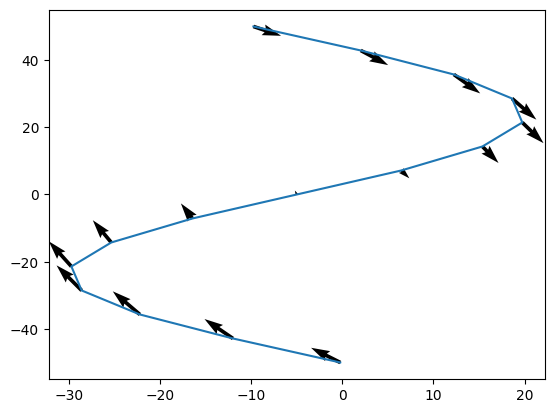

In [3]:
y_squ = np.linspace(-50, 50, 15)
x_squ = 25*np.sin(y_squ/15) - 5

plt.plot(x_squ, y_squ)

from scipy.interpolate import RegularGridInterpolator
interp_u = RegularGridInterpolator((y, x), u.T)
interp_v = RegularGridInterpolator((y, x), v.T)
points = np.vstack([y_squ, x_squ]).T
u_squ = interp_u(points)
v_squ = interp_v(points)

plt.quiver(x_squ, y_squ, u_squ, v_squ)



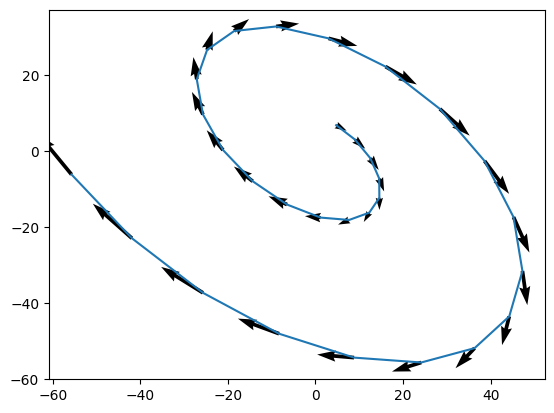

In [4]:
# drifter
N = 1
x_d = np.random.uniform(-10, 10, N)
y_d = np.random.uniform(-10, 10, N)

# Simulation params
dt = 9
steps = 30

trajectories_x = [x_d.copy()]
trajectories_y = [y_d.copy()]
trajectories_u = [np.full(N, np.nan)]
trajectories_v = [np.full(N, np.nan)]

for _ in range(steps):
    points = np.vstack([y_d, x_d]).T
    ud = interp_u(points)
    vd = interp_v(points)

    x_d += ud * dt
    y_d += vd * dt

    trajectories_x.append(x_d.copy())
    trajectories_y.append(y_d.copy())
    trajectories_u.append(ud.copy())
    trajectories_v.append(vd.copy())

# Convert to arrays
x_drif = np.array(trajectories_x)[1:]
y_drif = np.array(trajectories_y)[1:]
u_drif = np.array(trajectories_u)[1:]
v_drif = np.array(trajectories_v)[1:]


x_drif = [val[0] for val in x_drif]
y_drif = [val[0] for val in y_drif]
u_drif = [val[0] for val in u_drif]
v_drif = [val[0] for val in v_drif]

plt.plot(x_drif, y_drif)
plt.quiver(x_drif, y_drif, u_drif, v_drif)


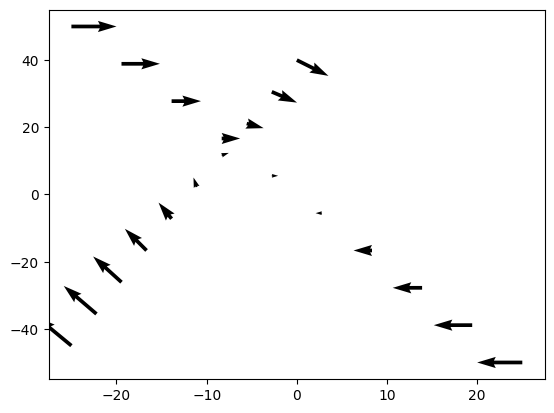

In [5]:
scaling = 5

x_l1 = np.linspace(-5*scaling, 0*scaling, 10)
y_l1 = np.linspace(-9*scaling, 8*scaling, 10)
points = np.vstack([y_l1, x_l1]).T
u_l1 = interp_u(points)
v_l1 = interp_v(points)
plt.quiver(x_l1, y_l1, u_l1, v_l1)

x_l2 = np.linspace(-5*scaling, 5*scaling, 10)
y_l2 = np.linspace(10*scaling, -10*scaling, 10)
points = np.vstack([y_l2, x_l2]).T
u_l2 = interp_u(points)
v_l2 = interp_v(points)
plt.quiver(x_l2, y_l2, u_l2, v_l2)

x_l = np.array(list(x_l1) + list(x_l2))
y_l = np.array(list(y_l1) + list(y_l2))
u_l = np.array(list(u_l1) + list(u_l2))
v_l = np.array(list(v_l1) + list(v_l2))


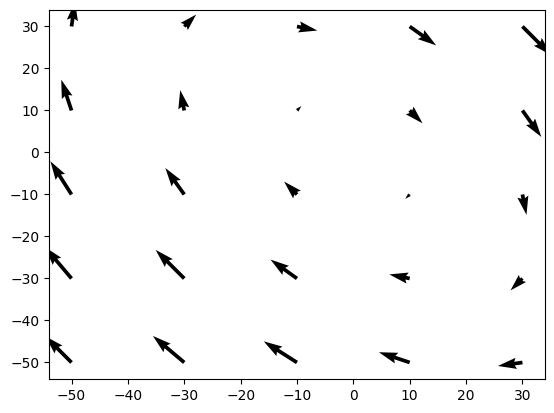

In [6]:
x_p = np.arange(-50, 50, 20)
y_p = np.arange(-50, 50, 20)
x_p, y_p = np.meshgrid(x_p, y_p)
x_p, y_p = x_p.flatten(), y_p.flatten()
points = np.vstack([y_p, x_p]).T
u_p = interp_u(points)
v_p = interp_v(points)
plt.quiver(x_p, y_p, u_p, v_p)


/home/z5297792/UNSW-MRes/MRes/modules/utils.py:375: RuntimeWarning: invalid value encountered in sqrt
  rho = np.sqrt(Q[0, 0]*dx**2 + 2*Q[0, 1]*dx*dy + Q[1, 1]*dy**2)


ValueError: Residuals are not finite in the initial point.

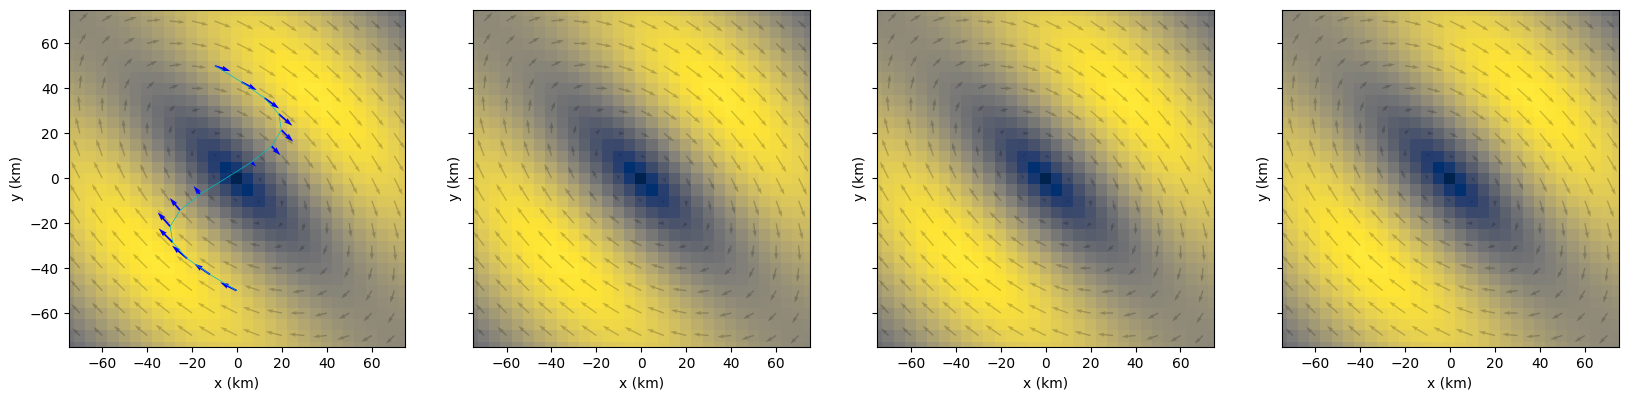

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# your data arrays: x, y, u, v, x_squ, y_squ, u_squ, v_squ, x_drif, y_drif, u_drif, v_drif,
# x_l1, y_l1, u_l1, v_l1, x_l2, y_l2, u_l2, v_l2, x_p, y_p, u_p, v_p, etc.

fig, axs = plt.subplots(1, 4, figsize=(20, 5), constrained_layout=False, sharey=True, sharex=True)

cmap = 'cividis'
spacing, scale, width = 2, 40, 0.004
wid = 1.3

# ---- plot background pcolor + quiver on each axis ----
for ax in axs:
    pc = ax.pcolor(x, y, np.hypot(u, v).T, cmap=cmap)
    ax.quiver(
        x[::spacing], y[::spacing],
        u[::spacing, ::spacing].T, v[::spacing, ::spacing].T,
        alpha=0.2, scale=scale, width=width, zorder=1
    )
    ax.set_aspect('equal', 'box')
    ax.set_xlim(-75, 75)
    ax.set_ylim(-75, 75)
    ax.set_xlabel('x (km)')
    ax.set_ylabel('y (km)')

# ---- Panel 1: Example S-ADCP Data ----
axs[0].plot(x_squ, y_squ, 'c', linewidth=.5)
axs[0].quiver(x_squ, y_squ, u_squ, v_squ, scale=scale*1, width=width*wid, color='b')
xc, yc, w, Q, Rc, psi0, q = espra(x_squ, y_squ, u_squ, v_squ, Rc_init=4.0, psi0_init=210.0)
df_res.loc[len(df_res)] = {'xc': xc, 'yc': yc, 'w': w,
                           'Q11': Q[0,0], 'Q12': Q[1,0], 'Q22': Q[1,1],
                           'Rc': Rc, 'psi0': psi0,
                           'q11': q[0,0], 'q12': q[0,1], 'q22': q[1,1]}
x_ell, y_ell = plot_ellipse(Q, (xc, yc), scale=40)
axs[0].plot(x_ell, y_ell, 'r')
axs[0].scatter(xc, yc, marker='x', s=100, color='r', zorder=10)
axs[0].set_title('Example S-ADCP Data')

# ---- Panel 2: Example Drifter Data ----
axs[1].plot(x_drif, y_drif, 'c', linewidth=.5)
axs[1].quiver(x_drif, y_drif, u_drif, v_drif, scale=scale*1, width=width*wid, color='b', zorder=3)
xc, yc, w, Q, Rc, psi0, q = espra(x_drif, y_drif, u_drif, v_drif, Rc_init=4.0, psi0_init=210.0)
df_res.loc[len(df_res)] = {'xc': xc, 'yc': yc, 'w': w,
                           'Q11': Q[0,0], 'Q12': Q[1,0], 'Q22': Q[1,1],
                           'Rc': Rc, 'psi0': psi0,
                           'q11': q[0,0], 'q12': q[0,1], 'q22': q[1,1]}
axs[1].scatter(xc, yc, marker='x', s=100, color='r', zorder=10)
x_ell, y_ell = plot_ellipse(Q, (xc, yc), scale=40)
axs[1].plot(x_ell, y_ell, 'r', zorder=3)
axs[1].set_title('Example Drifter Data')

# ---- Panel 3: Example Transect Data ----
axs[2].plot(x_l1, y_l1, 'c', linewidth=.5)
axs[2].plot(x_l2, y_l2, 'c', linewidth=.5)
axs[2].quiver(x_l1, y_l1, u_l1, v_l1, scale=scale*1, width=width*wid, color='b', zorder=3)
axs[2].quiver(x_l2, y_l2, u_l2, v_l2, scale=scale*1, width=width*wid, color='b', zorder=3)
xc, yc, w, Q, Rc, psi0, q = espra(x_l, y_l, u_l, v_l, Rc_init=4.0, psi0_init=210.0)
df_res.loc[len(df_res)] = {'xc': xc, 'yc': yc, 'w': w,
                           'Q11': Q[0,0], 'Q12': Q[1,0], 'Q22': Q[1,1],
                           'Rc': Rc, 'psi0': psi0,
                           'q11': q[0,0], 'q12': q[0,1], 'q22': q[1,1]}
axs[2].scatter(xc, yc, marker='x', s=100, color='r', zorder=10)
x_ell, y_ell = plot_ellipse(Q, (xc, yc), scale=40)
axs[2].plot(x_ell, y_ell, 'r', zorder=3)
axs[2].set_title('Example Transect Data')

# ---- Panel 4: Example Gridded Data ----
# horizontal transects
for i in range(0, 25, 5):
    axs[3].plot([x_p[i], x_p[i+4]], [y_p[i], y_p[i+4]], 'c', linewidth=.5)
# vertical transects
for i in range(5):
    axs[3].plot([x_p[i], x_p[i+20]], [y_p[i], y_p[i+20]], 'c', linewidth=.5)
axs[3].quiver(x_p, y_p, u_p, v_p, scale=scale*1, width=width*wid, color='b', zorder=3)
xc, yc, w, Q, Rc, psi0, q = espra(x_p, y_p, u_p, v_p, Rc_init=4.0, psi0_init=210.0)
df_res.loc[len(df_res)] = {'xc': xc, 'yc': yc, 'w': w,
                           'Q11': Q[0,0], 'Q12': Q[1,0], 'Q22': Q[1,1],
                           'Rc': Rc, 'psi0': psi0,
                           'q11': q[0,0], 'q12': q[0,1], 'q22': q[1,1]}
axs[3].scatter(xc, yc, marker='x', s=100, color='r', zorder=10)
x_ell, y_ell = plot_ellipse(Q, (xc, yc), scale=40)
axs[3].plot(x_ell, y_ell, 'r', zorder=3)
axs[3].set_title('Example Gridded Data')

# ---- now place one colorbar to the right of the entire figure ----
# leave room on the right
fig.subplots_adjust(right=0.85)

# [left, bottom, width, height] in figure coords
cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])
fig.colorbar(pc, cax=cbar_ax, orientation='vertical', label=r'CS [ms$^{-1}$]')

plt.show()
df_res


In [ ]:
data = df_res.iloc[4]

spac, scale = 3, 40
fig, axs = plt.subplots(1, 2, figsize=(10,4))
axs[0].quiver(
    x[::spac], y[::spac],
    u[::spac, ::spac].T, v[::spac, ::spac].T,
    scale=scale,
)
axs[0].axis('equal')
# axs[0].set_xlim(-75, 75)
# axs[0].set_ylim(-75, 75)
axs[0].set_title('Original')

u_reco, v_reco, *_ = gaussian_vel_reconstruction(data.xc, data.yc, data.q11, data.q12, data.q22, data.Rc, data.psi0, X, Y)

axs[1].quiver(X[::spac,::spac], Y[::spac,::spac], u_reco[::spac,::spac], v_reco[::spac,::spac], scale=scale)
axs[1].axis('equal')
# axs[1].set_xlim(-75, 75)
# axs[1].set_ylim(-75, 75)
axs[1].set_title('Reco')

plt.tight_layout()
